In [1]:
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

2022-11-27 22:12:04.459439: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-27 22:12:05.052541: W tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libnvinfer.so.8'; dlerror: libnvinfer.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:
2022-11-27 22:12:05.052586: W tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libnvinfer_plugin.so.8'; dlerror: libnvinfer_plugin.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:
2022-11-27 22:12:05.052590: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT librar

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path

import jax
import jax.numpy as jnp
import neural_tangents as nt
from neural_tangents import stax
from jax.example_libraries import stax as ostax
from flax.training.checkpoints import restore_checkpoint

import tensorflow_datasets as tfds

/home/pc3090/miniconda3/envs/jax/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
np.random.seed(42)

In [4]:
NUM_CLASSES = 10
SEED = 42

In [5]:
name = 'mnist'
ds = tfds.load(name, split=tfds.Split.TRAIN).shuffle(1024, seed=42)
train_ds, test_ds = tfds.load('mnist:3.*.*', split=['train[:80%]', 'train[80%:]'])

def preprocess(x):
    image, label = x['image'], x['label']
    image = tf.cast(image, tf.float32)
    image = image / 255.
    image = tf.reshape(image, (-1,))
    # label = 1 if label % 2 == 0 else 0
    label = int(label)
    return image, label

train_ds = train_ds.map(preprocess).as_numpy_iterator()
test_ds = test_ds.map(preprocess).as_numpy_iterator()

def load_x_y(ds):
    x_list, y_list = [], []
    for x, y in ds:
        x = x / np.linalg.norm(x)
        y = np.eye(NUM_CLASSES)[y]
        x_list.append(x)
        y_list.append(y)
    return np.stack(x_list, axis=0), np.stack(y_list, axis=0)

train_x, train_y = load_x_y(train_ds)
test_x, test_y = load_x_y(test_ds)

In [6]:
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(48000, 784) (12000, 784) (48000, 10) (12000, 10)


In [7]:
train_length = 20000
test_length = 10000
inds = np.random.randint(0, train_x.shape[0], train_length)
train_x = train_x[inds]
train_y = train_y[inds]
inds = np.random.randint(0, test_x.shape[0], test_length)
test_x = test_x[inds]
test_y = test_y[inds]

test_x_copy = test_x.copy()

In [8]:
def ntk_adv(num_iter=10, epsilon=1e-3, plot=True):

    _,_,kernel_fn = stax.serial(stax.Dense(1024), stax.Relu(), stax.Dense(1))
    kernel_fn = jax.jit(kernel_fn, static_argnums=(2,))

    K_train = kernel_fn(train_x, train_x, 'ntk')
    K_inv = jnp.linalg.inv(K_train + K_train.shape[0] * 1e-8 * jnp.eye(K_train.shape[0]))

    def predict(x_test):
        K_new = kernel_fn(train_x, x_test, 'ntk')
        return K_new.T @ K_inv @ train_y

    def loss_fn(test_x, test_y):
        pred = predict(x_test=test_x)
        loss = (0.5 * (pred - test_y) ** 2).mean()
        return loss

    def evaluate(test_x, test_y):
        pred = predict(x_test=test_x)
        y_pred = jnp.argmax(pred, axis=-1)
        gt = jnp.argmax(test_y, axis=-1)
        accuracy = jnp.mean(y_pred == gt)
        return y_pred, accuracy

    def update(test_x, test_y):
        grad = jax.grad(loss_fn)(test_x, test_y)
        grad = jnp.reshape(grad, test_x.shape)
        x_adv = test_x + epsilon * jnp.sign(grad)
        return x_adv
    
    def plot_grid(x, before=None, after=None):
        cnt = 0
        ncol, nrow = 5, 2
        for i in range(ncol * nrow):
            cnt += 1
            plt.subplot(nrow, ncol, cnt)
            if before is not None and after is not None:
                plt.title(f"{before['pred'][i]} -> {after['pred'][i]}")
            plt.imshow(x[i].reshape(28, 28, 1))
        plt.show()
        plt.close()
    
    x = test_x_copy.copy()
    if plot:
        plot_grid(x[:10])
    
    pred, acc = evaluate(x, test_y)
    before = {'pred': jax.device_get(pred), 'acc': jax.device_get(acc)}

    acc_list = [acc]
    for step in tqdm(range(num_iter)):
        x = update(x, test_y)
        _, acc = evaluate(x, test_y)
        acc_list.append(acc)

    pred, acc = evaluate(x, test_y)
    after = {'pred': jax.device_get(pred), 'acc': jax.device_get(acc)}

    if plot:
        plt.plot(acc_list)
        plt.xlabel('iteration')
        plt.ylabel('accuracy')
        plt.ylim(0, 1)
        plt.grid()
        plt.show()
        plt.close()

    if plot:
        plot_grid(x[:10], before, after)

    print(f'Accuracy: {before["acc"]} -> {after["acc"]}')
    del K_train, K_inv
    return acc_list
    

2022-11-27 22:12:16.163617: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/nvptx_compiler.cc:492] The NVIDIA driver's CUDA version is 11.7 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


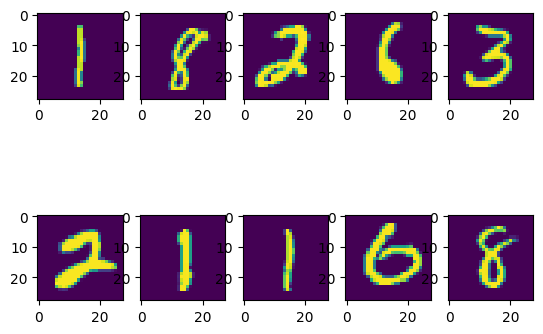

100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


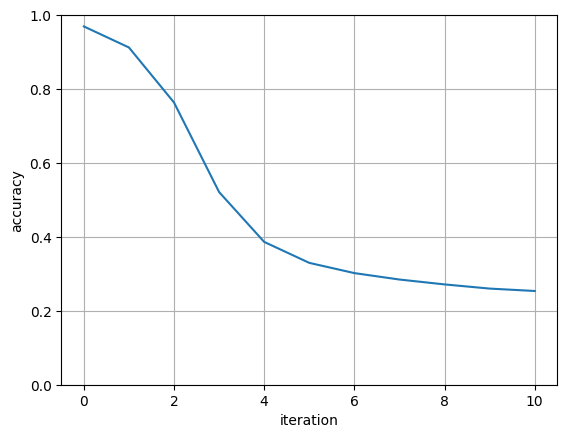

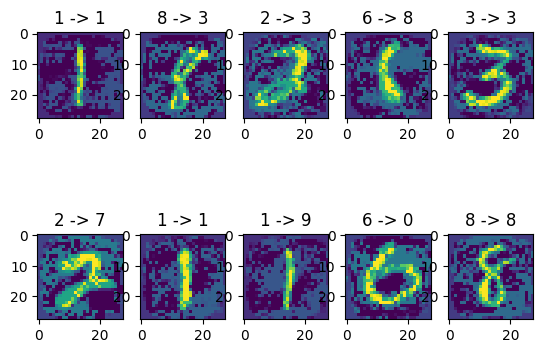

Accuracy: 0.9693999886512756 -> 0.25360000133514404


In [9]:
acc_list_ntk = ntk_adv(epsilon=3e-3)

In [10]:
def gauss_adv(num_iter=10, epsilon=1e-3, plot=True):
    @jax.jit
    def kernel_fn(x, y, theta1=1., theta2=1.):
        k = (
            jnp.sum(jnp.square(x), axis=1).reshape(-1, 1)
            + jnp.sum(jnp.square(y), axis=1)
            - 2 * x @ y.T
        )
        return theta1 * jnp.exp(-0.5 / theta2 * k)

    K_train = jax.device_get(kernel_fn(train_x, train_x))
    K_inv = jnp.linalg.inv(K_train + K_train.shape[0] * 1e-5 * jnp.eye(K_train.shape[0]))
    del K_train

    @jax.jit
    def predict(x_test):
        K_new = kernel_fn(train_x, x_test)
        return K_new.T @ K_inv @ train_y

    @jax.jit
    def loss_fn(test_x, test_y):
        pred = predict(x_test=test_x)
        loss = (0.5 * (pred - test_y) ** 2).mean()
        return loss

    @jax.jit
    def evaluate(test_x, test_y):
        pred = predict(x_test=test_x)
        y_pred = jnp.argmax(pred, axis=-1)
        gt = jnp.argmax(test_y, axis=-1)
        accuracy = jnp.mean(y_pred == gt)
        return y_pred, accuracy

    @jax.jit
    def update(test_x, test_y):
        grad = jax.grad(loss_fn)(test_x, test_y)
        grad = jnp.reshape(grad, test_x.shape)
        x_adv = test_x + epsilon * jnp.sign(grad)
        return x_adv
    
    def plot_grid(x, before=None, after=None):
        cnt = 0
        ncol, nrow = 5, 2
        for i in range(ncol * nrow):
            cnt += 1
            plt.subplot(nrow, ncol, cnt)
            if before is not None and after is not None:
                plt.title(f"{before['pred'][i]} -> {after['pred'][i]}")
            plt.imshow(x[i].reshape(28, 28, 1))
        plt.show()
        plt.close()
    
    x = test_x_copy.copy()
    if plot:
        plot_grid(x[:10])
    
    pred, acc = evaluate(x, test_y)
    before = {'pred': jax.device_get(pred), 'acc': jax.device_get(acc)}

    acc_list = [acc]
    for step in tqdm(range(num_iter)):
        x = update(x, test_y)
        _, acc = evaluate(x, test_y)
        acc_list.append(acc)

    pred, acc = evaluate(x, test_y)
    after = {'pred': jax.device_get(pred), 'acc': jax.device_get(acc)}

    if plot:
        plt.plot(acc_list)
        plt.xlabel('iteration')
        plt.ylabel('accuracy')
        plt.ylim(0, 1)
        plt.grid()
        plt.show()
        plt.close()

    if plot:
        plot_grid(x[:10], before, after)

    print(f'Accuracy: {before["acc"]} -> {after["acc"]}')
    del K_inv
    return acc_list
    

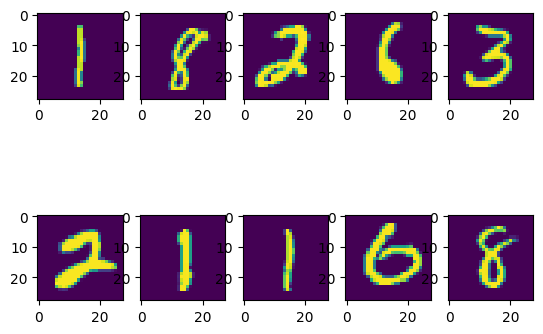

100%|██████████| 10/10 [00:23<00:00,  2.33s/it]


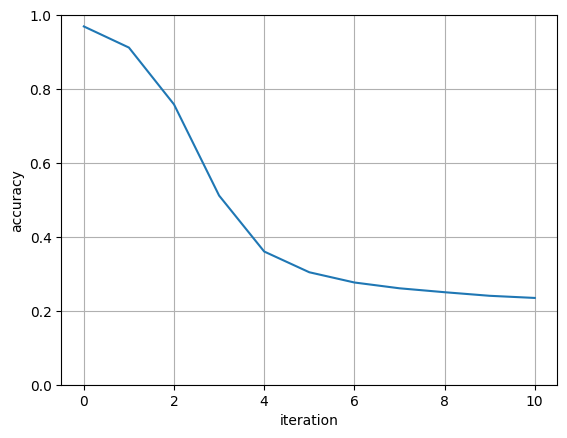

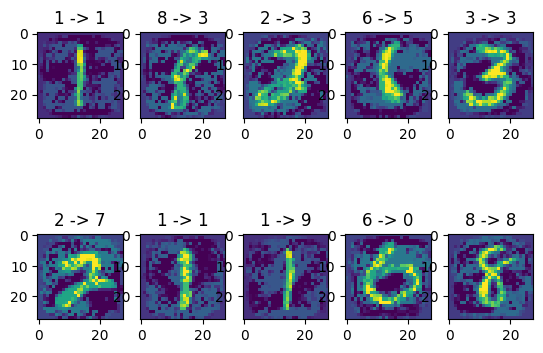

Accuracy: 0.9693999886512756 -> 0.23479999601840973


In [11]:
acc_list_gauss = gauss_adv(epsilon=3e-3)

In [12]:
def nn_adv(channels, ckpt_dir, num_iter=10, epsilon=1e-3, plot=True):

    init_fn, apply_fn = ostax.serial(
        ostax.Dense(channels),
        ostax.Relu,
        ostax.Dense(NUM_CLASSES)
    )
    
    _, init_params = init_fn(jax.random.PRNGKey(seed=SEED), (-1, 28*28))

    params = restore_checkpoint(ckpt_dir, target=init_params)

    @jax.jit
    def loss_fn(params, test_x, test_y):
        pred = apply_fn(params, test_x)
        loss = (0.5 * (pred - test_y) ** 2).mean()
        return loss

    @jax.jit
    def evaluate(params, test_x, test_y):
        pred = apply_fn(params, test_x)
        y_pred = jnp.argmax(pred, axis=-1)
        gt = jnp.argmax(test_y, axis=-1)
        accuracy = jnp.mean(y_pred == gt)
        return y_pred, accuracy

    @jax.jit
    def update(params, test_x, test_y):
        grad = jax.grad(loss_fn, argnums=1)(params, test_x, test_y)
        grad = jnp.reshape(grad, test_x.shape)
        x_adv = test_x + epsilon * jnp.sign(grad)
        return x_adv
    
    def plot_grid(x, before=None, after=None):
        cnt = 0
        ncol, nrow = 5, 2
        for i in range(ncol * nrow):
            cnt += 1
            plt.subplot(nrow, ncol, cnt)
            if before is not None and after is not None:
                plt.title(f"{before['pred'][i]} -> {after['pred'][i]}")
            plt.imshow(x[i].reshape(28, 28, 1))
        plt.show()
        plt.close()
    
    x = test_x_copy.copy()
    if plot:
        plot_grid(x[:10])
    
    pred, acc = evaluate(params, x, test_y)
    before = {'pred': jax.device_get(pred), 'acc': jax.device_get(acc)}

    acc_list = [acc]
    for step in tqdm(range(num_iter)):
        x = update(params, x, test_y)
        _, acc = evaluate(params, x, test_y)
        acc_list.append(acc)

    pred, acc = evaluate(params, x, test_y)
    after = {'pred': jax.device_get(pred), 'acc': jax.device_get(acc)}

    if plot:
        plt.plot(acc_list)
        plt.xlabel('iteration')
        plt.ylabel('accuracy')
        plt.ylim(0, 1)
        plt.grid()
        plt.show()
        plt.close()

    if plot:
        plot_grid(x[:10], before, after)

    print(f'Accuracy: {before["acc"]} -> {after["acc"]}')
    return acc_list

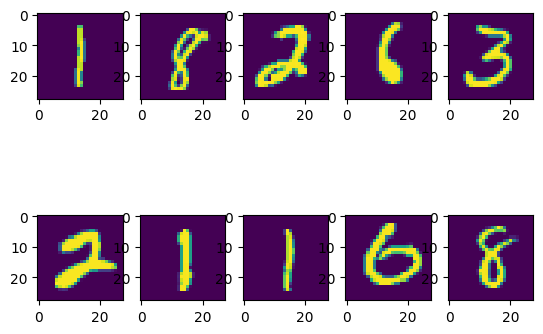

100%|██████████| 10/10 [00:00<00:00, 79.47it/s]


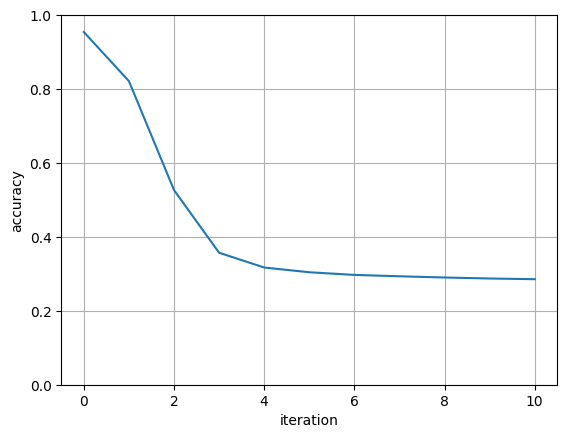

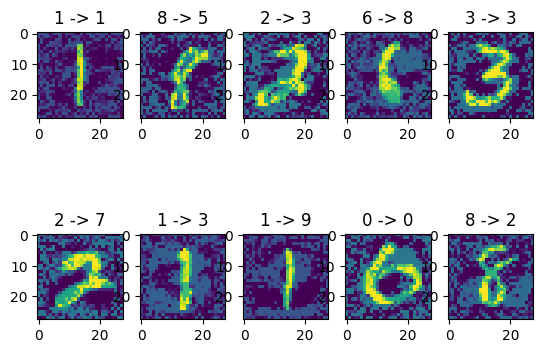

Accuracy: 0.9541999697685242 -> 0.2854999899864197


In [13]:
channels = 256
ckpt_dir = f"ckpt/mnist/channel_{channels}"
acc_list_256 = nn_adv(channels, ckpt_dir, epsilon=3e-3)

In [ ]:
channels = 512
ckpt_dir = f"ckpt/mnist/channel_{channels}"
acc_list_512 = nn_adv(channels, ckpt_dir, epsilon=3e-3)

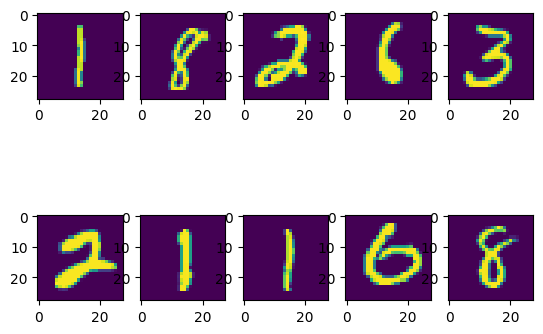

100%|██████████| 10/10 [00:00<00:00, 70.25it/s]


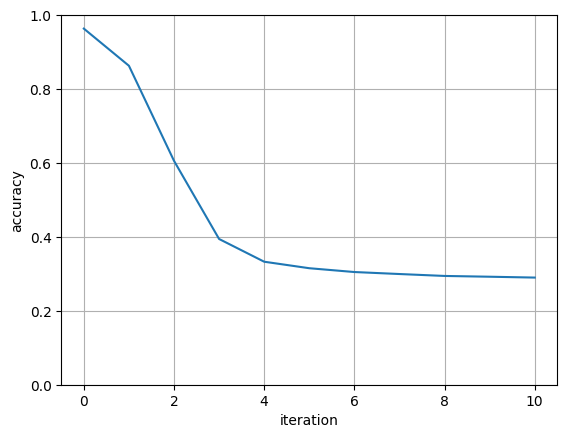

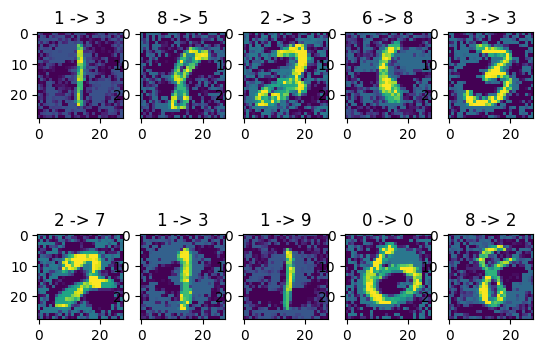

Accuracy: 0.9634999632835388 -> 0.289900004863739


In [14]:
channels = 1024
ckpt_dir = f"ckpt/mnist/channel_{channels}"
acc_list_1024 = nn_adv(channels, ckpt_dir, epsilon=3e-3)

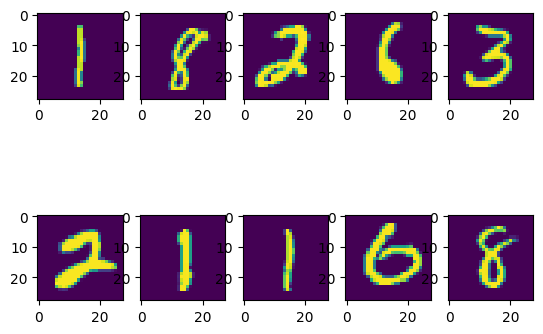

100%|██████████| 10/10 [00:00<00:00, 56.38it/s]


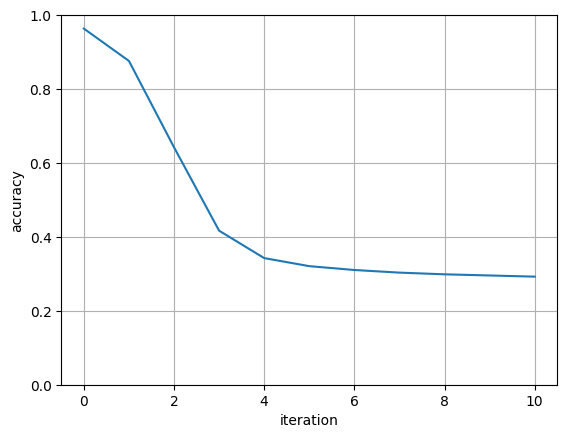

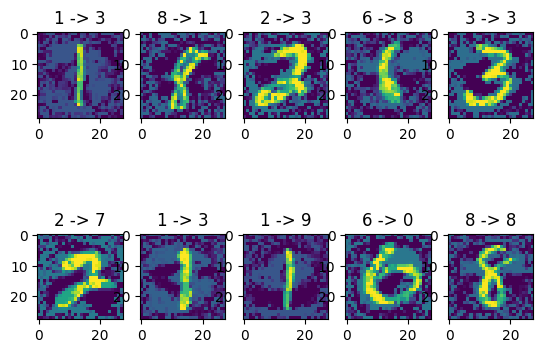

Accuracy: 0.9635999798774719 -> 0.2924000024795532


In [15]:
channels = 2048
ckpt_dir = f"ckpt/mnist/channel_{channels}"
acc_list_2048 = nn_adv(channels, ckpt_dir, epsilon=3e-3)

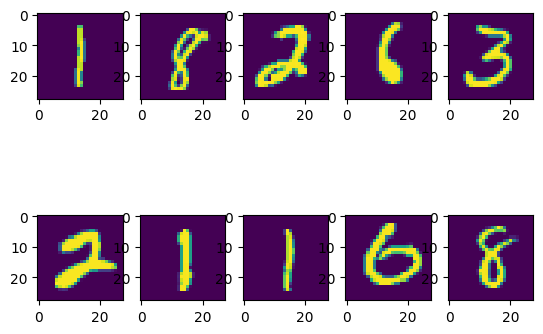

100%|██████████| 10/10 [00:00<00:00, 41.22it/s]


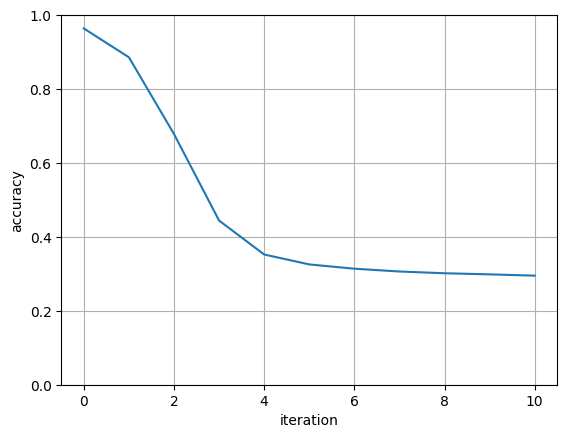

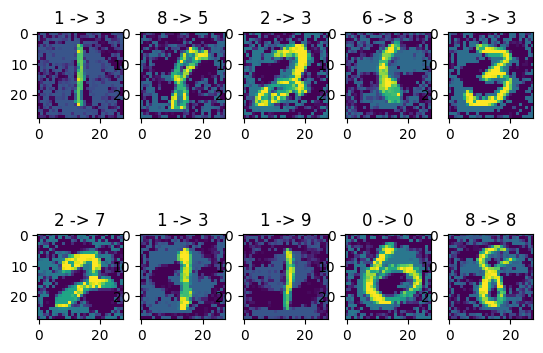

Accuracy: 0.9638999700546265 -> 0.29510000348091125


In [16]:
channels = 4096
ckpt_dir = f"ckpt/mnist/channel_{channels}"
acc_list_4096 = nn_adv(channels, ckpt_dir, epsilon=3e-3)

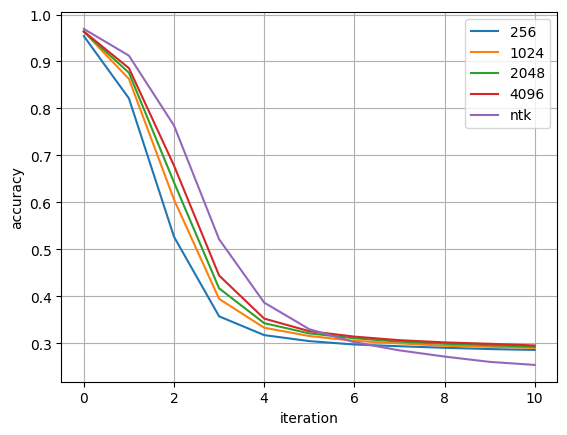

In [17]:
plt.plot(acc_list_256, label='256')
plt.plot(acc_list_512, label='512')
plt.plot(acc_list_1024, label='1024')
plt.plot(acc_list_2048, label='2048')
plt.plot(acc_list_4096, label='4096')
plt.plot(acc_list_ntk, label='ntk')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.grid()
plt.legend()
plt.show()

In [18]:
label_list = ['256', '1024', '2048', '4096', 'ntk', 'gauss']
epsilons = [1e-4, 2e-4, 5e-4, 1e-3, 2e-3, 5e-3, 7.5e-3]
acc_dict = {str(eps): {l: None for l in label_list} for eps in epsilons}
for epsilon in epsilons:
    print(epsilon)
    for label in label_list:
        if label == 'ntk':
            acc_list = ntk_adv(epsilon=epsilon, plot=False)
        elif label == 'gauss':
            acc_list = gauss_adv(epsilon=epsilon, plot=False)
        else:
            channels = int(label)
            ckpt_dir = f'ckpt/mnist/channel_{channels}'
            acc_list = nn_adv(channels, ckpt_dir, epsilon=epsilon, plot=False)
        acc_dict[str(epsilon)][label] = acc_list

0.0001


100%|██████████| 10/10 [00:00<00:00, 103.33it/s]

Accuracy: 0.9541999697685242 -> 0.9262999892234802



100%|██████████| 10/10 [00:00<00:00, 106.93it/s]


Accuracy: 0.9634999632835388 -> 0.9363999962806702


100%|██████████| 10/10 [00:00<00:00, 93.64it/s]


Accuracy: 0.9635999798774719 -> 0.9389999508857727


100%|██████████| 10/10 [00:00<00:00, 82.70it/s]


Accuracy: 0.9638999700546265 -> 0.9447000026702881


100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Accuracy: 0.9693999886512756 -> 0.9535999894142151


100%|██████████| 10/10 [00:15<00:00,  1.52s/it]


Accuracy: 0.9693999886512756 -> 0.9563999772071838
0.0002


100%|██████████| 10/10 [00:00<00:00, 98.73it/s]

Accuracy: 0.9541999697685242 -> 0.8851000070571899



100%|██████████| 10/10 [00:00<00:00, 105.31it/s]


Accuracy: 0.9634999632835388 -> 0.9043999910354614


100%|██████████| 10/10 [00:00<00:00, 94.98it/s]


Accuracy: 0.9635999798774719 -> 0.911899983882904


100%|██████████| 10/10 [00:00<00:00, 84.52it/s]


Accuracy: 0.9638999700546265 -> 0.9146999716758728


100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Accuracy: 0.9693999886512756 -> 0.9386000037193298


100%|██████████| 10/10 [00:15<00:00,  1.52s/it]


Accuracy: 0.9693999886512756 -> 0.9369999766349792
0.0005


100%|██████████| 10/10 [00:00<00:00, 100.83it/s]

Accuracy: 0.9541999697685242 -> 0.6085999608039856



100%|██████████| 10/10 [00:00<00:00, 102.25it/s]


Accuracy: 0.9634999632835388 -> 0.6926999688148499


100%|██████████| 10/10 [00:00<00:00, 95.32it/s]


Accuracy: 0.9635999798774719 -> 0.725600004196167


100%|██████████| 10/10 [00:00<00:00, 85.02it/s]


Accuracy: 0.9638999700546265 -> 0.7550999522209167


100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


Accuracy: 0.9693999886512756 -> 0.828499972820282


100%|██████████| 10/10 [00:15<00:00,  1.52s/it]


Accuracy: 0.9693999886512756 -> 0.8226999640464783
0.001


100%|██████████| 10/10 [00:00<00:00, 99.97it/s]


Accuracy: 0.9541999697685242 -> 0.3240000009536743


100%|██████████| 10/10 [00:00<00:00, 104.48it/s]


Accuracy: 0.9634999632835388 -> 0.3483999967575073


100%|██████████| 10/10 [00:00<00:00, 97.73it/s]


Accuracy: 0.9635999798774719 -> 0.36139997839927673


100%|██████████| 10/10 [00:00<00:00, 84.77it/s]


Accuracy: 0.9638999700546265 -> 0.38109999895095825


100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Accuracy: 0.9693999886512756 -> 0.4472000002861023


100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


Accuracy: 0.9693999886512756 -> 0.43359997868537903
0.002


100%|██████████| 10/10 [00:00<00:00, 96.74it/s]

Accuracy: 0.9541999697685242 -> 0.2938999831676483



100%|██████████| 10/10 [00:00<00:00, 96.66it/s]


Accuracy: 0.9634999632835388 -> 0.3001999855041504


100%|██████████| 10/10 [00:00<00:00, 93.80it/s]


Accuracy: 0.9635999798774719 -> 0.30469998717308044


100%|██████████| 10/10 [00:00<00:00, 80.94it/s]


Accuracy: 0.9638999700546265 -> 0.3077999949455261


100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Accuracy: 0.9693999886512756 -> 0.2897999882698059


100%|██████████| 10/10 [00:15<00:00,  1.52s/it]


Accuracy: 0.9693999886512756 -> 0.2639999985694885
0.005


100%|██████████| 10/10 [00:00<00:00, 97.03it/s]

Accuracy: 0.9541999697685242 -> 0.2775999903678894



100%|██████████| 10/10 [00:00<00:00, 103.00it/s]


Accuracy: 0.9634999632835388 -> 0.2773999869823456


100%|██████████| 10/10 [00:00<00:00, 93.02it/s]


Accuracy: 0.9635999798774719 -> 0.28129997849464417


100%|██████████| 10/10 [00:00<00:00, 82.60it/s]


Accuracy: 0.9638999700546265 -> 0.2824999988079071


100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Accuracy: 0.9693999886512756 -> 0.21619999408721924


100%|██████████| 10/10 [00:15<00:00,  1.52s/it]


Accuracy: 0.9693999886512756 -> 0.2142999917268753
0.0075


100%|██████████| 10/10 [00:00<00:00, 96.30it/s]

Accuracy: 0.9541999697685242 -> 0.2694999873638153



100%|██████████| 10/10 [00:00<00:00, 104.27it/s]


Accuracy: 0.9634999632835388 -> 0.26909998059272766


100%|██████████| 10/10 [00:00<00:00, 91.28it/s]


Accuracy: 0.9635999798774719 -> 0.273499995470047


100%|██████████| 10/10 [00:00<00:00, 80.62it/s]


Accuracy: 0.9638999700546265 -> 0.27489998936653137


100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Accuracy: 0.9693999886512756 -> 0.1899999976158142


100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


Accuracy: 0.9693999886512756 -> 0.20059999823570251


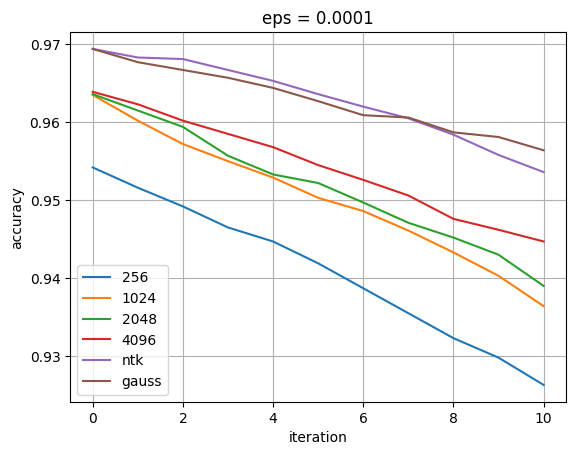

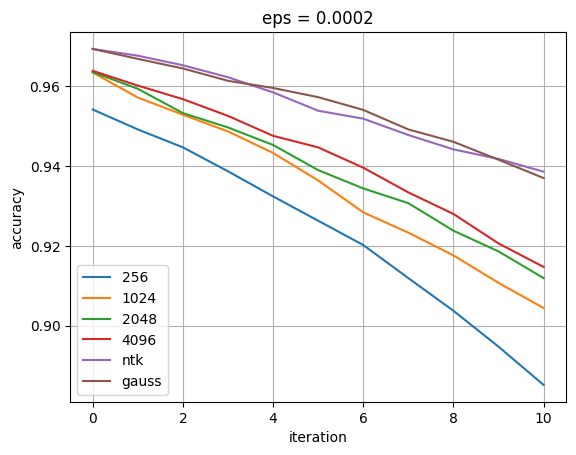

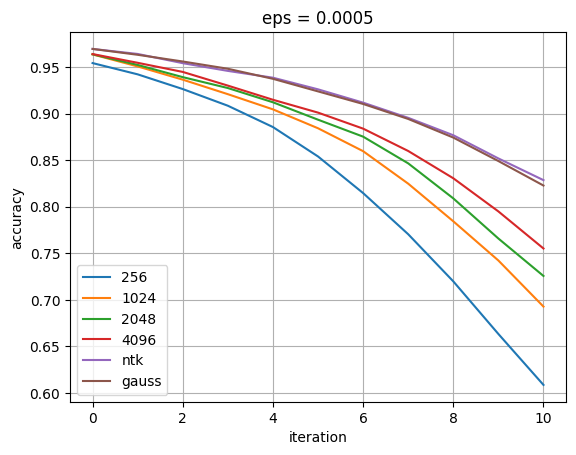

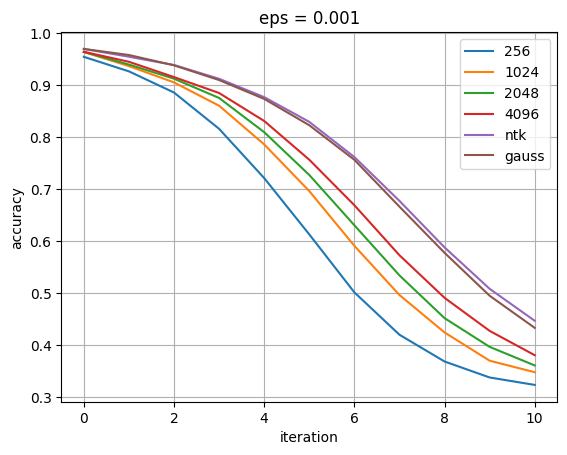

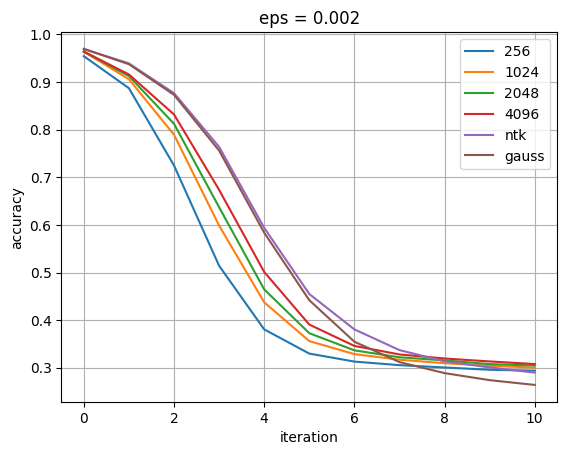

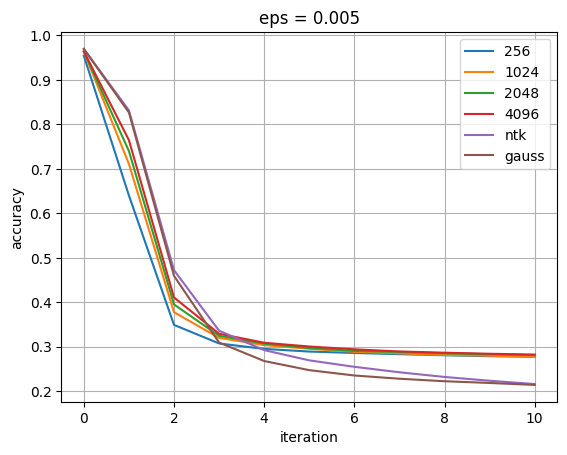

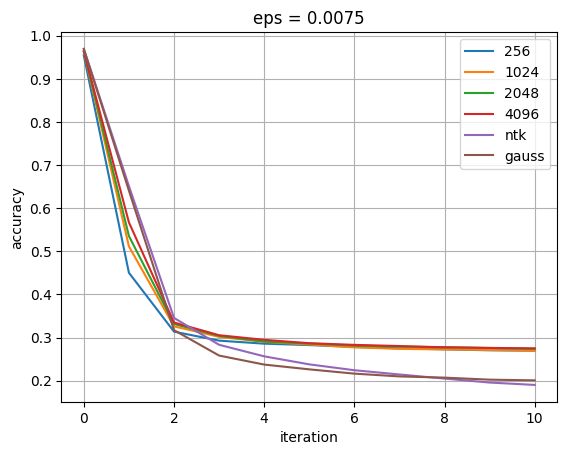

In [19]:
def plot_per_epsilon(epsilon):
    for k, v in acc_dict[str(epsilon)].items():
        plt.plot(v, label=k)
    plt.title(f'eps = {epsilon}')
    plt.xlabel('iteration')
    plt.ylabel('accuracy')
    plt.grid()
    plt.legend()
    plt.show()
    plt.close()

for eps in epsilons:
    plot_per_epsilon(eps)

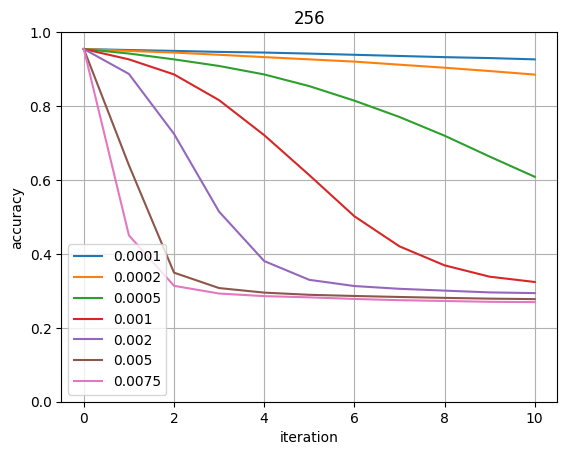

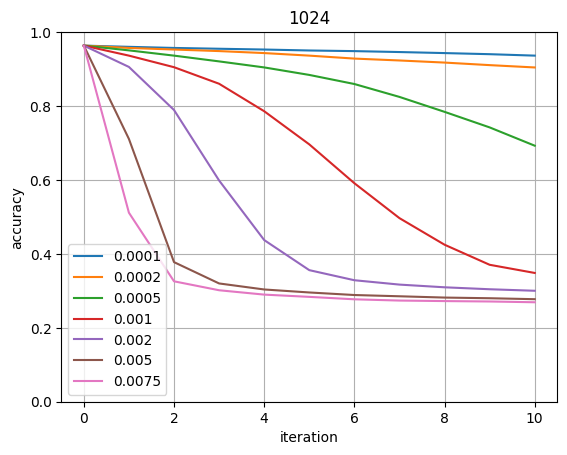

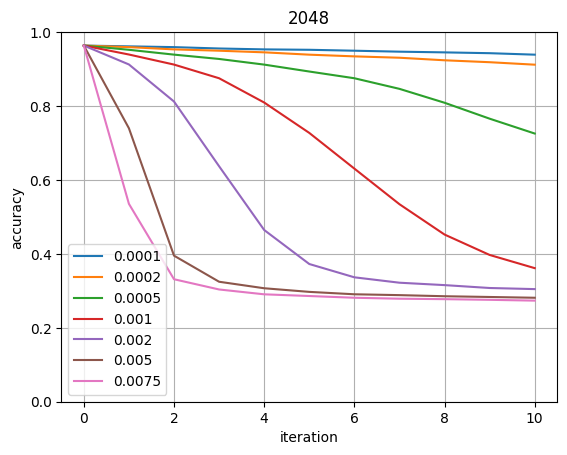

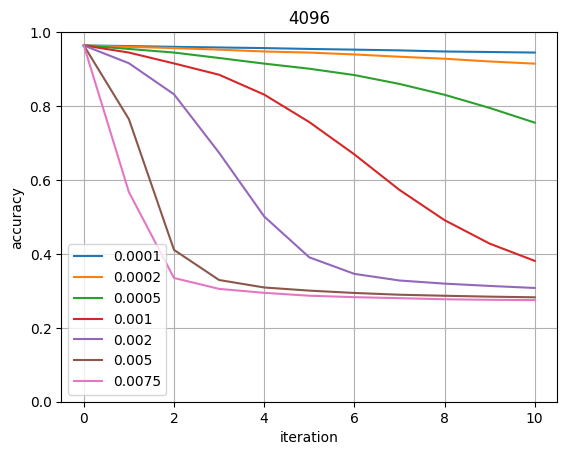

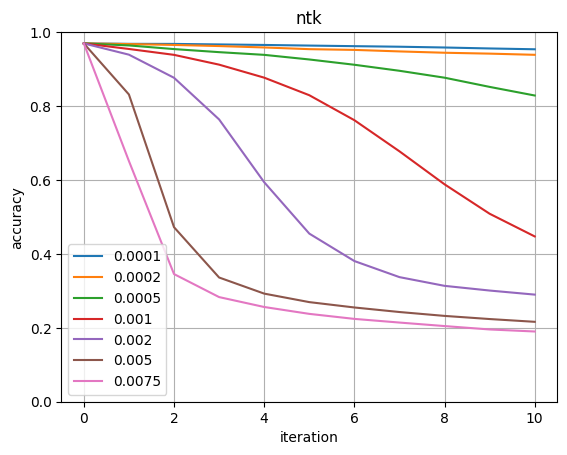

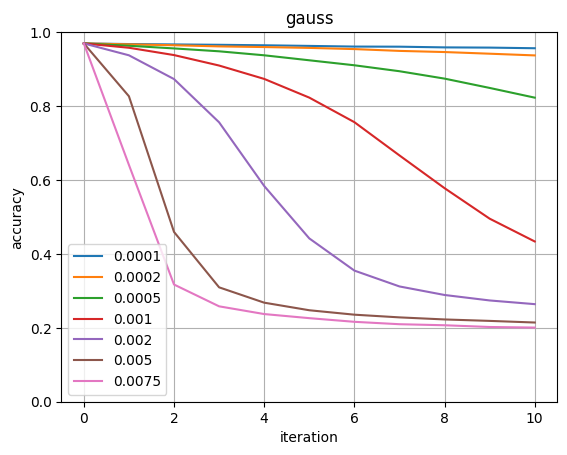

In [26]:
def plot_per_label(label, d):
    for k, v in d.items():
        plt.plot(v, label=k)
    plt.title(f'{label}')
    plt.xlabel('iteration')
    plt.ylabel('accuracy')
    plt.ylim(0, 1)
    plt.grid()
    plt.legend()
    plt.show()
    plt.close()

for label in label_list:
    d = {k: v[label] for k, v in acc_dict.items()}
    plot_per_label(label, d)

Start Epsilon = 0.0001


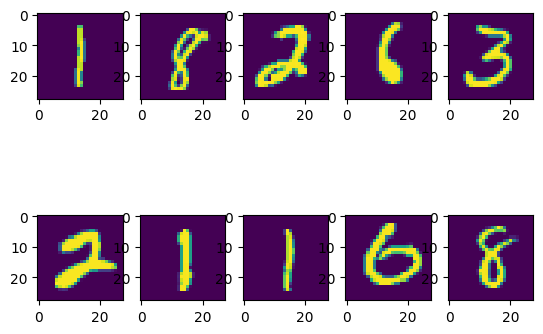

100%|██████████| 10/10 [00:00<00:00, 162.98it/s]


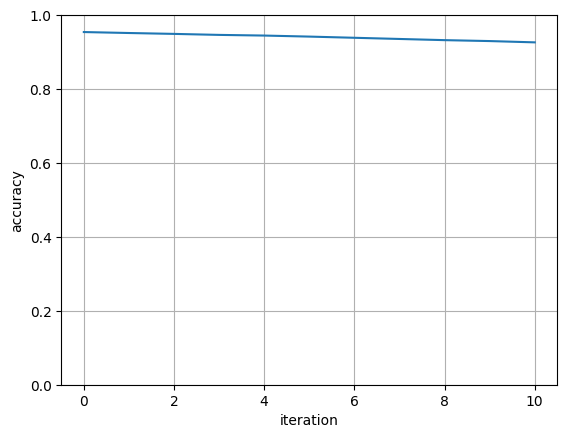

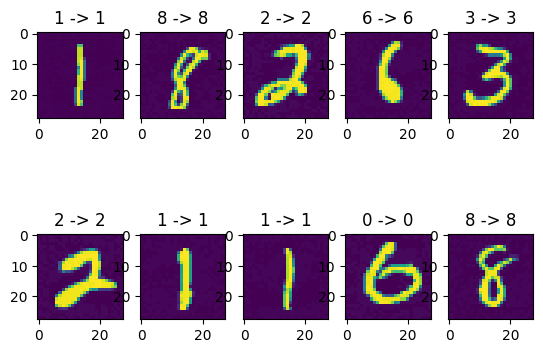

Accuracy: 0.9541999697685242 -> 0.9262999892234802
Start Epsilon = 0.0002


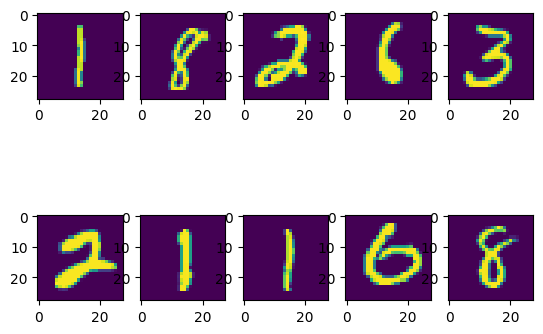

100%|██████████| 10/10 [00:00<00:00, 165.55it/s]


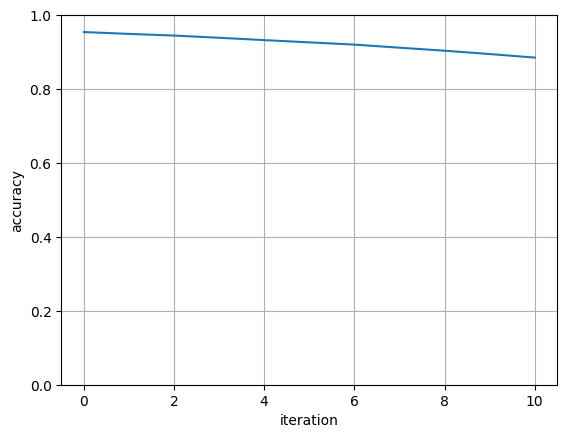

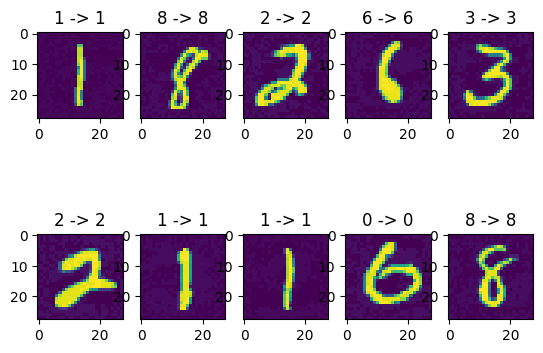

Accuracy: 0.9541999697685242 -> 0.8851000070571899
Start Epsilon = 0.0005


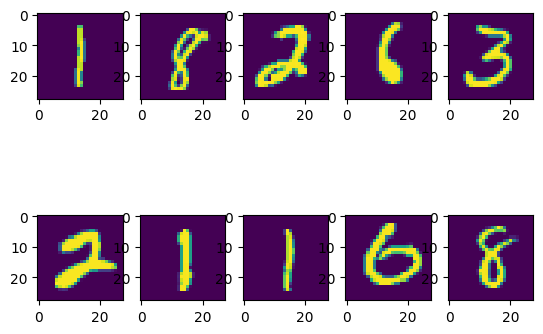

100%|██████████| 10/10 [00:00<00:00, 170.41it/s]


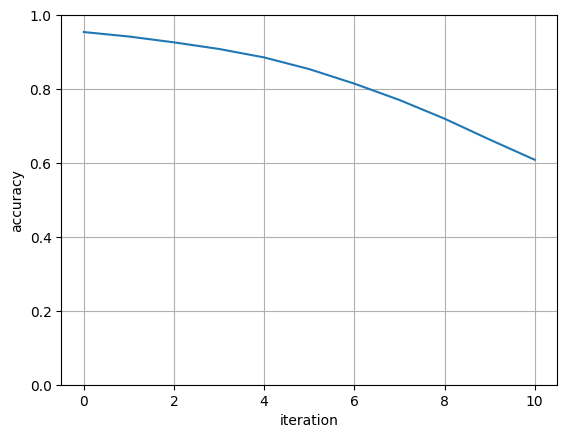

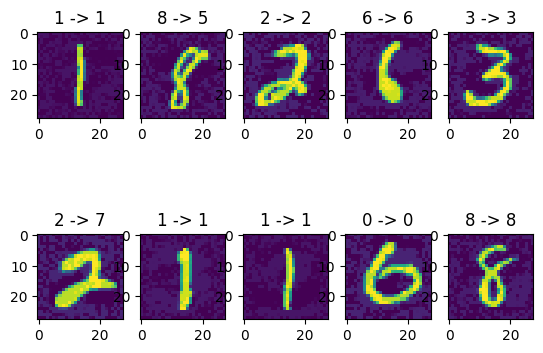

Accuracy: 0.9541999697685242 -> 0.6085999608039856
Start Epsilon = 0.001


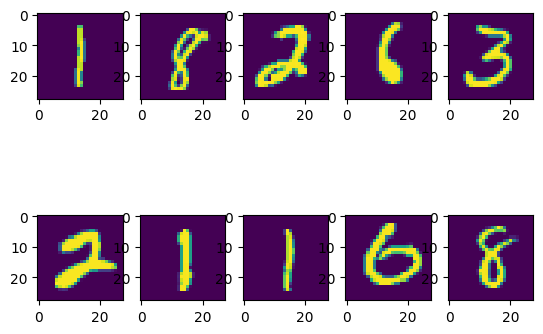

100%|██████████| 10/10 [00:00<00:00, 160.40it/s]


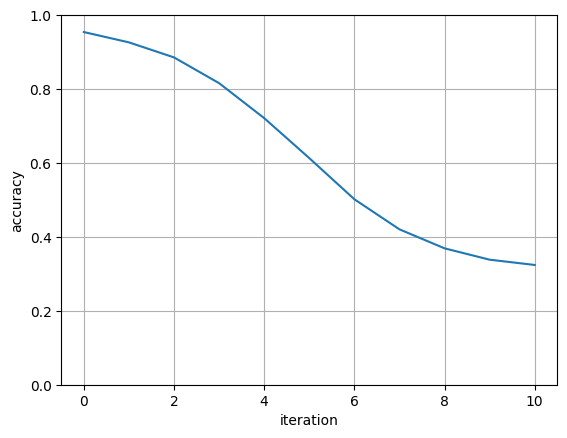

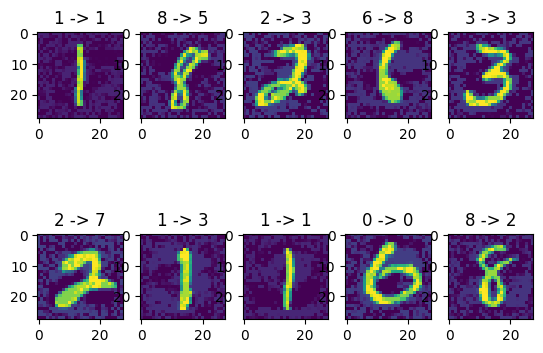

Accuracy: 0.9541999697685242 -> 0.3240000009536743
Start Epsilon = 0.002


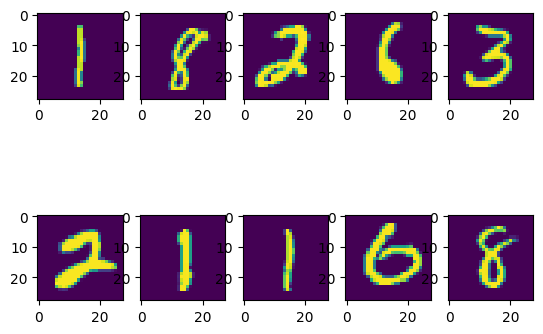

100%|██████████| 10/10 [00:00<00:00, 168.35it/s]


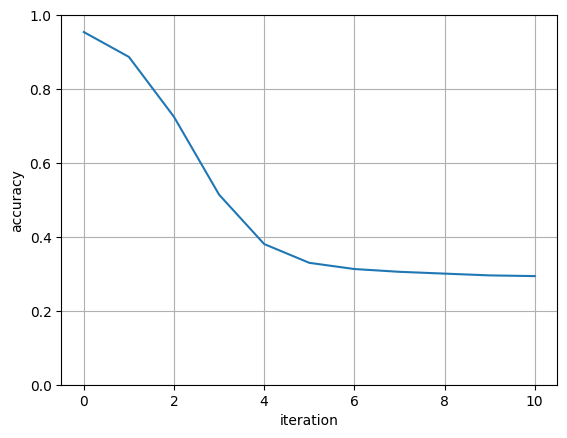

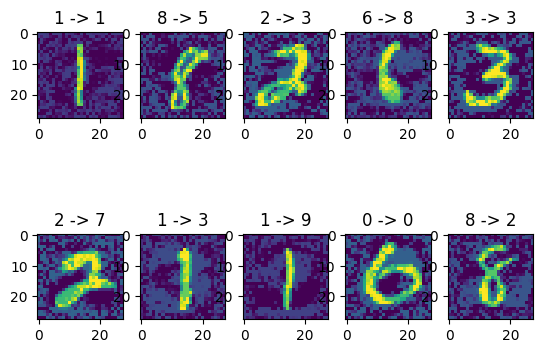

Accuracy: 0.9541999697685242 -> 0.2938999831676483
Start Epsilon = 0.005


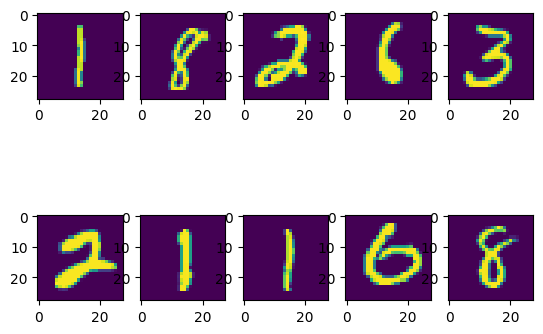

100%|██████████| 10/10 [00:00<00:00, 166.20it/s]


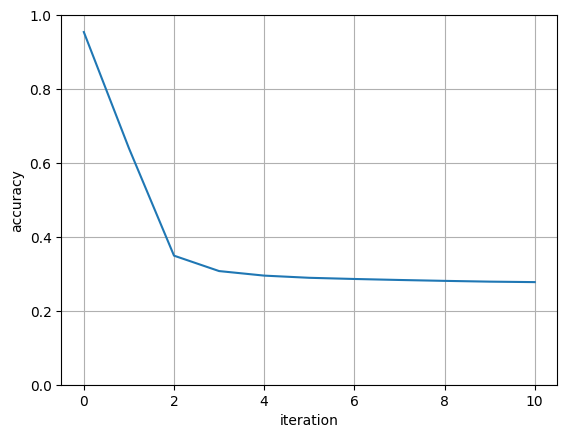

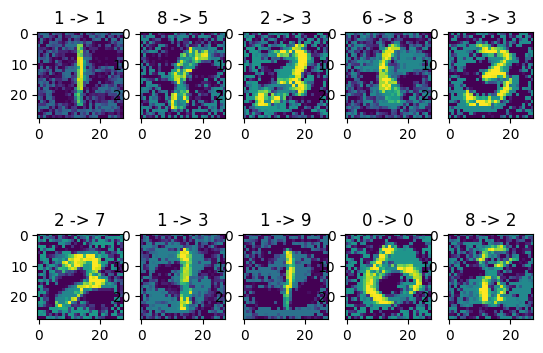

Accuracy: 0.9541999697685242 -> 0.2775999903678894
Start Epsilon = 0.0075


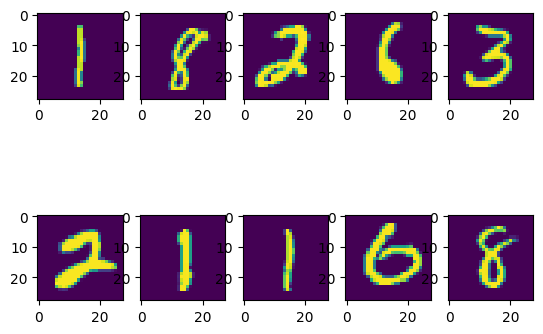

100%|██████████| 10/10 [00:00<00:00, 167.21it/s]


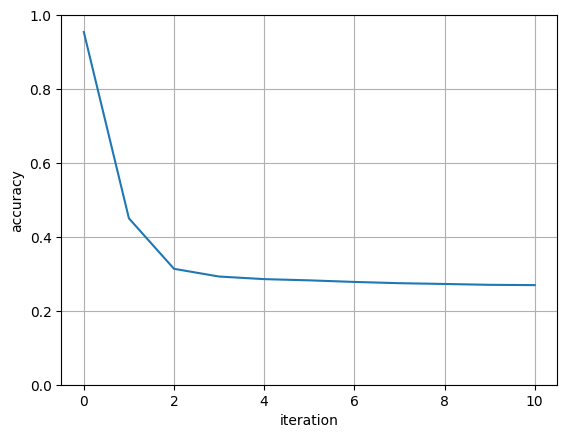

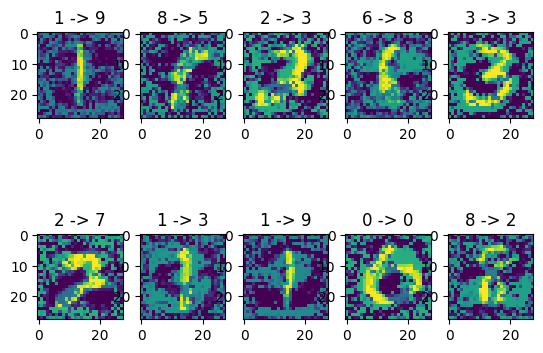

Accuracy: 0.9541999697685242 -> 0.2694999873638153


In [22]:
for eps in epsilons:
    print(f"Start Epsilon = {eps}")
    channels = 256
    ckpt_dir = "ckpt/mnist/channel_256"
    _ = nn_adv(channels, ckpt_dir, epsilon=eps)